# WiDS Datathon 2026 - Exploratory Data Analysis

**Workshop Session 1: Understanding the Data**

This notebook explores the wildfire prediction dataset through visualizations and statistical analysis.

## Learning Objectives
1. Understand the survival analysis problem structure
2. Explore target variable distributions
3. Analyze feature patterns and relationships
4. Identify data quality issues
5. Discover insights for modeling

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [3]:
# Load data
train_df = pd.read_csv('../WiDSWorldWide_GlobalDathon26/train.csv')
test_df = pd.read_csv('../WiDSWorldWide_GlobalDathon26/test.csv')
metadata_df = pd.read_csv('../WiDSWorldWide_GlobalDathon26/metaData.csv')

print(f"Training data: {train_df.shape[0]} rows × {train_df.shape[1]} columns")
print(f"Test data: {test_df.shape[0]} rows × {test_df.shape[1]} columns")
print(f"\n✓ Data loaded successfully!")

Training data: 221 rows × 37 columns
Test data: 95 rows × 35 columns

✓ Data loaded successfully!


In [4]:
# Quick peek at the data
print("First 3 rows of training data:")
train_df.head(3)

First 3 rows of training data:


,event_id,num_perimeters_0_5h,dt_first_last_0_5h,low_temporal_resolution_0_5h,area_first_ha,area_growth_abs_0_5h,area_growth_rel_0_5h,area_growth_rate_ha_per_h,log1p_area_first,log1p_growth,log_area_ratio_0_5h,relative_growth_0_5h,radial_growth_m,radial_growth_rate_m_per_h,centroid_displacement_m,centroid_speed_m_per_h,spread_bearing_deg,spread_bearing_sin,spread_bearing_cos,dist_min_ci_0_5h,dist_std_ci_0_5h,dist_change_ci_0_5h,dist_slope_ci_0_5h,closing_speed_m_per_h,closing_speed_abs_m_per_h,projected_advance_m,dist_accel_m_per_h2,dist_fit_r2_0_5h,alignment_cos,alignment_abs,cross_track_component,along_track_speed,event_start_hour,event_start_dayofweek,event_start_month,time_to_hit_hours,event
0,10892457,3,4.265188,0,79.696304,2.875935,0.036086,0.674281,4.390693,1.354787,0.03545,0.036086,9.007182,2.11179,8.274971,1.940119,70.130507,0.940469,0.339879,6166.121596,0.205085,0.435052,1.090997e-01,-0.102001,0.102001,-0.435052,7.275611e-02,0.886373,-0.054649,0.054649,-1.937219,-0.106026,19,4,5,18.892512,0
1,11757157,2,1.169918,0,8.946749,0.000000,0.000000,0.000000,2.297246,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,2930.925956,0.000000,0.000000,-3.887003e-13,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.568898,0.568898,-0.000000,-0.000000,4,4,6,22.048108,1
2,11945086,4,4.777526,0,106.482638,0.000000,0.000000,0.000000,4.677329,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,3272.375090,0.000000,0.000000,-1.390327e-13,0.000000,0.000000,0.000000,7.965118e-14,0.000000,0.882385,0.882385,0.000000,0.000000,22,4,8,0.888895,1


## 2. Understanding the Problem: Survival Analysis

This is a **survival analysis** problem, not standard classification!

### Key Concepts:
- **Event**: Fire reaches within 5km of evacuation zone
- **Time-to-event**: Hours from t0+5h until fire hits
- **Censoring**: Fire didn't hit within 72h observation window (69% of data!)
- **Goal**: Predict probability of hitting at 12h, 24h, 48h, 72h

### 2.1 Target Variable Distribution

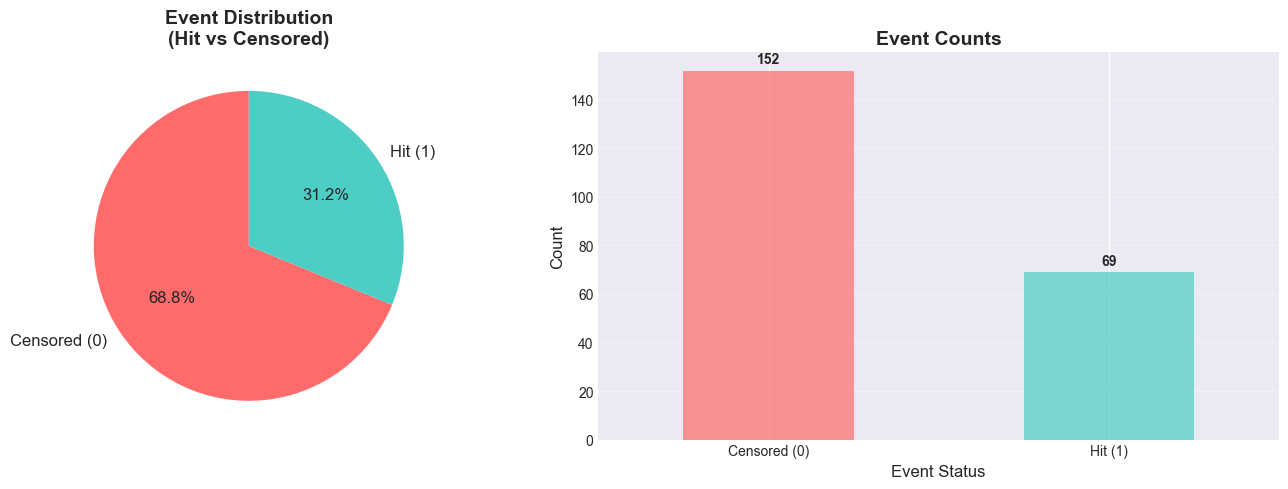


📊 Key Statistics:
   Hits (event=1): 69 (31.2%)
   Censored (event=0): 152 (68.8%)

⚠️  High censoring rate (69%) - must use survival analysis methods!


In [5]:
# Event distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
event_counts = train_df['event'].value_counts()
colors = ['#ff6b6b', '#4ecdc4']
axes[0].pie(event_counts, labels=['Censored (0)', 'Hit (1)'], autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12})
axes[0].set_title('Event Distribution\n(Hit vs Censored)', fontsize=14, fontweight='bold')

# Bar chart with counts
event_counts.plot(kind='bar', ax=axes[1], color=colors, alpha=0.7)
axes[1].set_title('Event Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Event Status', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticklabels(['Censored (0)', 'Hit (1)'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(event_counts):
    axes[1].text(i, v + 3, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Key Statistics:")
print(f"   Hits (event=1): {event_counts[1]} ({event_counts[1]/len(train_df)*100:.1f}%)")
print(f"   Censored (event=0): {event_counts[0]} ({event_counts[0]/len(train_df)*100:.1f}%)")
print(f"\n⚠️  High censoring rate (69%) - must use survival analysis methods!")

### 2.2 Time-to-Event Distribution

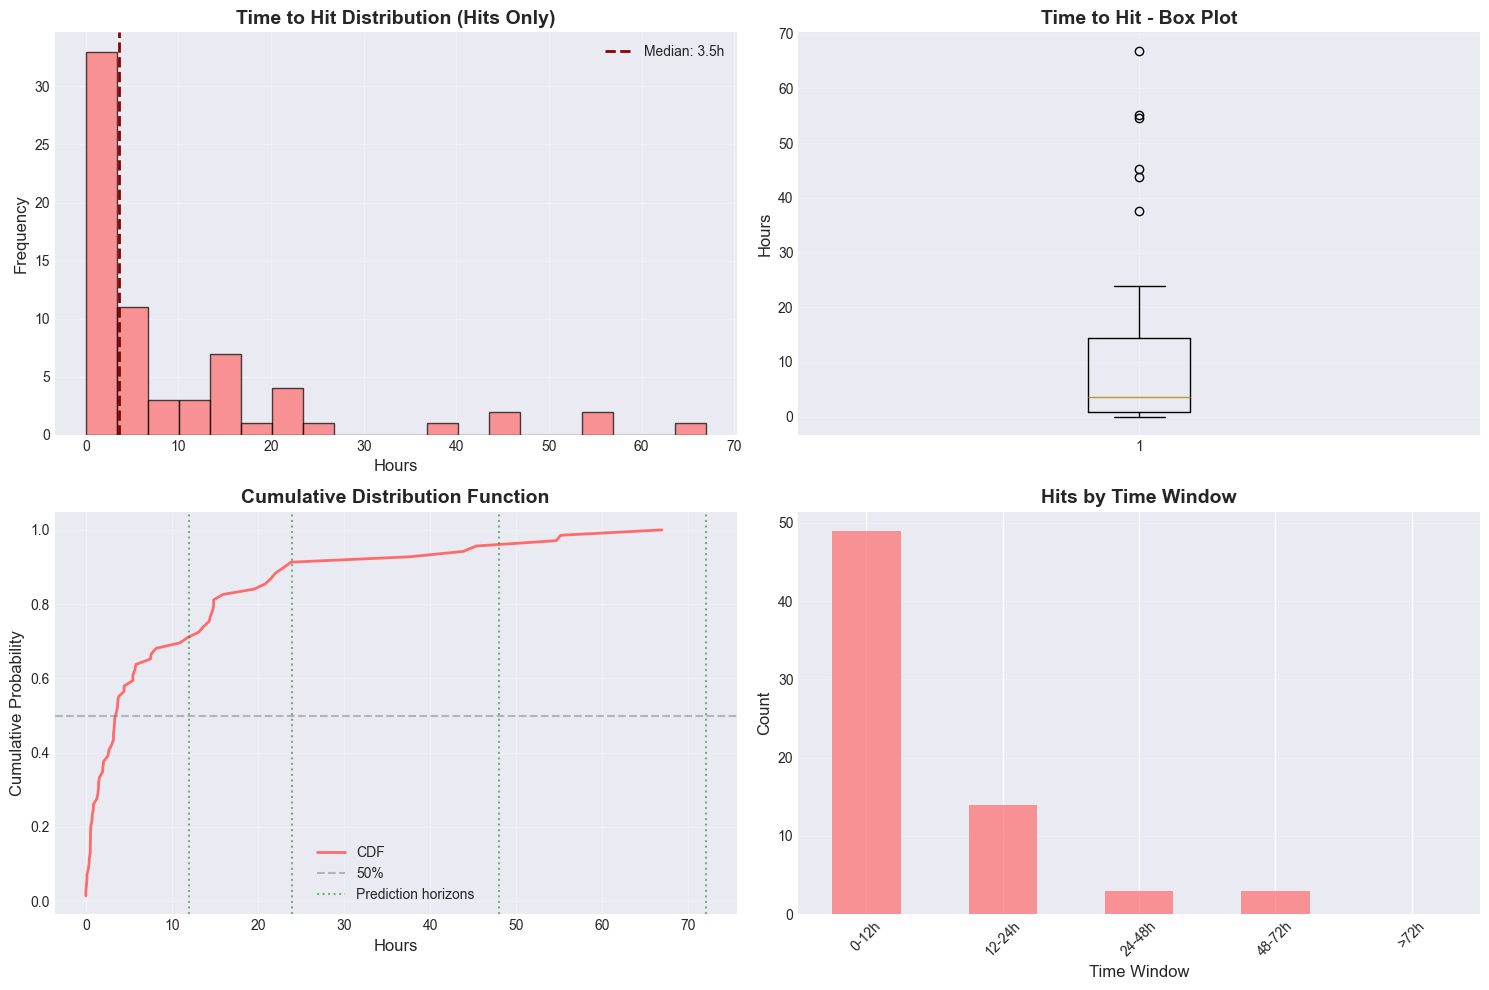


📊 Time-to-Hit Statistics (for 69 hits):
count    69.000000
mean      9.969870
std      14.528462
min       0.001220
25%       0.888895
50%       3.534846
75%      14.323375
max      66.920463
Name: time_to_hit_hours, dtype: float64

⏱️  Fastest hit: 0.00 hours
⏱️  Slowest hit: 66.92 hours


In [6]:
# Time to hit distribution (for hits only)
hits_df = train_df[train_df['event'] == 1]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(hits_df['time_to_hit_hours'], bins=20, color='#ff6b6b', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(hits_df['time_to_hit_hours'].median(), color='darkred', 
                   linestyle='--', linewidth=2, label=f'Median: {hits_df["time_to_hit_hours"].median():.1f}h')
axes[0, 0].set_title('Time to Hit Distribution (Hits Only)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hours', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot
axes[0, 1].boxplot(hits_df['time_to_hit_hours'], vert=True)
axes[0, 1].set_title('Time to Hit - Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Hours', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# Cumulative distribution
sorted_times = np.sort(hits_df['time_to_hit_hours'])
cumulative = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
axes[1, 0].plot(sorted_times, cumulative, linewidth=2, color='#ff6b6b')
axes[1, 0].axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='50%')
for h in [12, 24, 48, 72]:
    axes[1, 0].axvline(h, color='green', linestyle=':', alpha=0.5)
axes[1, 0].set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hours', fontsize=12)
axes[1, 0].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend(['CDF', '50%', 'Prediction horizons'])

# Time categories
time_bins = [0, 12, 24, 48, 72, 100]
time_labels = ['0-12h', '12-24h', '24-48h', '48-72h', '>72h']
hits_df_copy = hits_df.copy()
hits_df_copy['time_category'] = pd.cut(hits_df_copy['time_to_hit_hours'], bins=time_bins, labels=time_labels)
time_counts = hits_df_copy['time_category'].value_counts().sort_index()
time_counts.plot(kind='bar', ax=axes[1, 1], color='#ff6b6b', alpha=0.7)
axes[1, 1].set_title('Hits by Time Window', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Time Window', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_xticklabels(time_labels, rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Time-to-Hit Statistics (for {len(hits_df)} hits):")
print(hits_df['time_to_hit_hours'].describe())
print(f"\n⏱️  Fastest hit: {hits_df['time_to_hit_hours'].min():.2f} hours")
print(f"⏱️  Slowest hit: {hits_df['time_to_hit_hours'].max():.2f} hours")

## 3. The Single-Perimeter Challenge

**Critical Finding**: 72% of fires have only 1 perimeter observation!

This means:
- Can't calculate growth rates (need 2+ observations)
- Can't calculate movement (need 2+ observations)
- Must rely on distance and initial size features

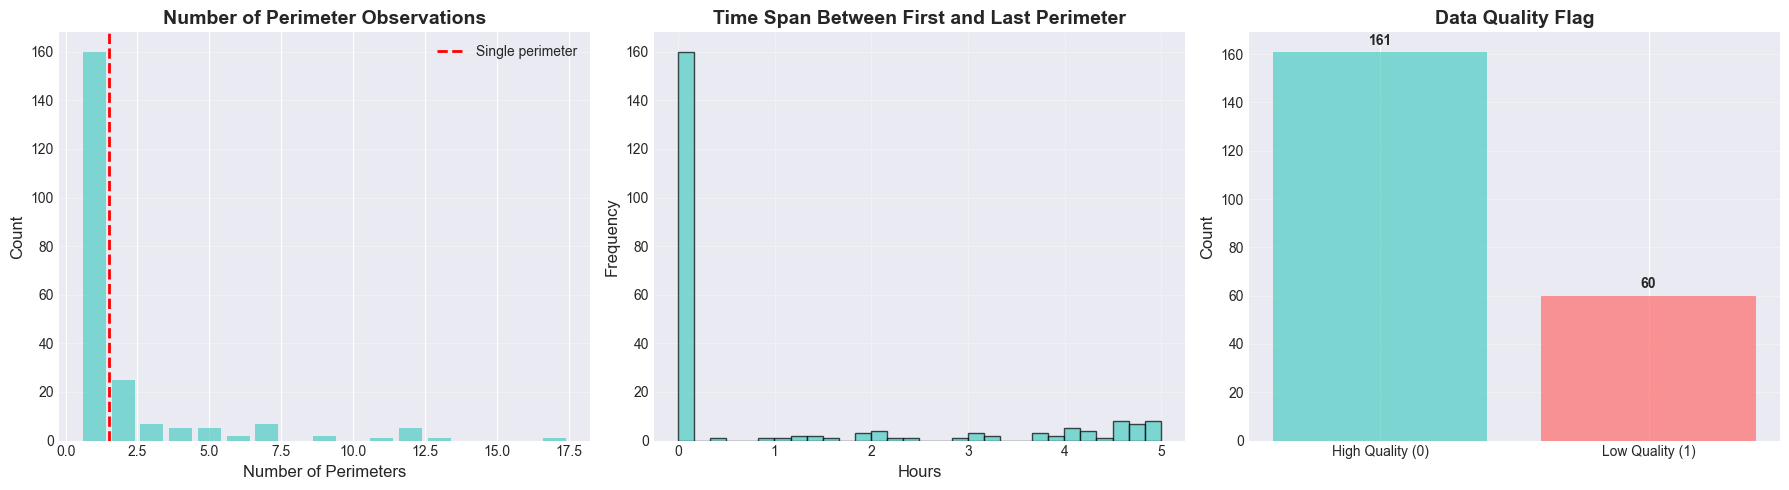


📊 Temporal Coverage Statistics:
   Single perimeter fires: 160 (72.4%)
   Multiple perimeter fires: 61 (27.6%)

⚠️  72% of fires have limited temporal data!


In [7]:
# Analyze temporal coverage
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Number of perimeters distribution
perimeter_counts = train_df['num_perimeters_0_5h'].value_counts().sort_index()
axes[0].bar(perimeter_counts.index, perimeter_counts.values, color='#4ecdc4', alpha=0.7)
axes[0].set_title('Number of Perimeter Observations', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Perimeters', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].axvline(1.5, color='red', linestyle='--', linewidth=2, label='Single perimeter')
axes[0].legend()

# Time span distribution
axes[1].hist(train_df['dt_first_last_0_5h'], bins=30, color='#4ecdc4', alpha=0.7, edgecolor='black')
axes[1].set_title('Time Span Between First and Last Perimeter', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hours', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(alpha=0.3)

# Low temporal resolution flag - FIXED to show correct colors
low_res_counts = train_df['low_temporal_resolution_0_5h'].value_counts().sort_index()
colors_res = ['#4ecdc4', '#ff6b6b']  # Green for 0 (good), Red for 1 (bad)
axes[2].bar(['High Quality (0)', 'Low Quality (1)'], low_res_counts.values, color=colors_res, alpha=0.7)
axes[2].set_title('Data Quality Flag', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(low_res_counts.values):
    axes[2].text(i, v + 3, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

single_perimeter = (train_df['num_perimeters_0_5h'] == 1).sum()
print(f"\n📊 Temporal Coverage Statistics:")
print(f"   Single perimeter fires: {single_perimeter} ({single_perimeter/len(train_df)*100:.1f}%)")
print(f"   Multiple perimeter fires: {len(train_df) - single_perimeter} ({(len(train_df) - single_perimeter)/len(train_df)*100:.1f}%)")
print(f"\n⚠️  72% of fires have limited temporal data!")

## 4. Distance Features - THE Most Important!

Distance to evacuation zones is likely the strongest predictor.

In [ ]:
# Analyze minimum distance to zones
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution by event status
hits = train_df[train_df['event'] == 1]['dist_min_ci_0_5h']
censored = train_df[train_df['event'] == 0]['dist_min_ci_0_5h']

axes[0, 0].hist([hits/1000, censored/1000], bins=30, label=['Hits', 'Censored'], 
                color=['#ff6b6b', '#4ecdc4'], alpha=0.7)
axes[0, 0].axvline(5, color='red', linestyle='--', linewidth=2, label='5km threshold')
axes[0, 0].set_title('Minimum Distance Distribution by Event Status', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Distance (km)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot comparison
train_df.boxplot(column='dist_min_ci_0_5h', by='event', ax=axes[0, 1])
axes[0, 1].set_title('Distance by Event Status', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Event (0=Censored, 1=Hit)', fontsize=12)
axes[0, 1].set_ylabel('Distance (meters)', fontsize=12)
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Censored', 'Hit'])

# Log scale distribution
axes[1, 0].hist([np.log10(hits + 1), np.log10(censored + 1)], bins=30, 
                label=['Hits', 'Censored'], color=['#ff6b6b', '#4ecdc4'], alpha=0.7)
axes[1, 0].set_title('Distance Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Log10(Distance + 1)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Distance categories
def categorize_distance(dist):
    if dist < 5000:
        return '<5km (Immediate)'
    elif dist < 20000:
        return '5-20km (Near-term)'
    elif dist < 50000:
        return '20-50km (Medium-term)'
    else:
        return '>50km (Low risk)'

train_df_copy = train_df.copy()
train_df_copy['distance_category'] = train_df_copy['dist_min_ci_0_5h'].apply(categorize_distance)
dist_event = pd.crosstab(train_df_copy['distance_category'], train_df_copy['event'], normalize='index') * 100
dist_event.plot(kind='bar', stacked=True, ax=axes[1, 1], color=['#4ecdc4', '#ff6b6b'], alpha=0.7)
axes[1, 1].set_title('Hit Rate by Distance Category', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Distance Category', fontsize=12)
axes[1, 1].set_ylabel('Percentage', fontsize=12)
axes[1, 1].legend(['Censored', 'Hit'], title='Event')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Distance Statistics:")
print(f"\nHits (event=1):")
print(f"   Mean: {hits.mean()/1000:.1f} km")
print(f"   Median: {hits.median()/1000:.1f} km")
print(f"   Min: {hits.min()/1000:.1f} km")
print(f"\nCensored (event=0):")
print(f"   Mean: {censored.mean()/1000:.1f} km")
print(f"   Median: {censored.median()/1000:.1f} km")
print(f"   Min: {censored.min()/1000:.1f} km")
print(f"\n🎯 Fires that hit are MUCH closer on average!")

## 5. Key Insights Summary

### 🔥 Critical Findings:

1. **High Censoring (69%)**: Must use survival analysis methods
2. **Single-Perimeter Dominance (72%)**: Most fires lack growth/movement data
3. **Distance is King**: Closest fires are much more likely to hit
4. **Time Distribution**: Hits range from 0.5 to 72 hours
5. **Data Quality Varies**: 60 high-quality fires vs 160 low-quality

### 🎯 Modeling Implications:

1. **Feature Selection**: Focus on distance, initial size, temporal metadata
2. **Handle Zeros**: Don't treat as missing - they're informative
3. **Stratified CV**: Balance hit/censored in validation folds
4. **Survival Models**: Cox, Random Survival Forest, or IPCW-weighted classification
5. **Calibration**: Critical for Brier score (70% of final metric)

### 📊 Next Steps:

1. Review ydata-profiling HTML reports for detailed analysis
2. Explore additional feature categories (growth, kinematics, directionality)
3. Identify redundant features
4. Plan modeling strategy
5. Design cross-validation approach

## Workshop Discussion Questions

1. **Why is this a survival analysis problem and not classification?**
2. **What challenges does the 72% single-perimeter rate create?**
3. **Why is distance likely the strongest predictor?**
4. **How should we handle censored observations in modeling?**
5. **What validation strategy makes sense for this small dataset?**